In [22]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_1samp
import torch

from src.encoding.ecog.timit import trf_grid_to_df

In [21]:
subject = "EC183"
dataset = "timit"

model1 = "baseline"
model2 = "syllable"

model1_scores_path = f"outputs/encoders/{dataset}/{model1}/{subject}/scores.csv"
model2_scores_path = f"outputs/encoders/{dataset}/{model2}/{subject}/scores.csv"
model1_coefs_path = f"outputs/encoders/{dataset}/{model1}/{subject}/coefs.pkl"
model2_coefs_path = f"outputs/encoders/{dataset}/{model2}/{subject}/coefs.pkl"
model1_model_path = f"outputs/encoders/{dataset}/{model1}/{subject}/model.pkl"
model2_model_path = f"outputs/encoders/{dataset}/{model2}/{subject}/model.pkl"

model2_permutation_score_paths = {
    "units": [
        f"outputs/encoders-permute_units/0/{dataset}/{model2}/{subject}/scores.csv",
        f"outputs/encoders-permute_units/1/{dataset}/{model2}/{subject}/scores.csv",
        f"outputs/encoders-permute_units/2/{dataset}/{model2}/{subject}/scores.csv",
        f"outputs/encoders-permute_units/3/{dataset}/{model2}/{subject}/scores.csv",
        f"outputs/encoders-permute_units/4/{dataset}/{model2}/{subject}/scores.csv",
    ],
}

output_dir = "."

In [9]:
model1_scores = pd.read_csv(model1_scores_path)
model2_scores = pd.read_csv(model2_scores_path)

In [10]:
model2_permutation_scores = {
    permutation_name: pd.concat([
            pd.read_csv(permutation_scores_path)
            for permutation_scores_path in permutation_scores_paths
        ], names=["permutation_idx"], keys=range(len(permutation_scores_paths)))
    for permutation_name, permutation_scores_paths in model2_permutation_score_paths.items()
}
model2_permutation_scores = pd.concat(model2_permutation_scores, names=["permutation"]) \
    .droplevel(-1).set_index(["output_dim", "fold"], append=True)
model2_permutation_scores

score    output_name
permutation permutation_idx output_dim fold                         
units       0               0          0    -0.003769      (0, 'G1')
                                       1    -0.003453      (0, 'G1')
                                       2    -0.001306      (0, 'G1')
                            1          0    -0.002372      (1, 'G2')
                                       1    -0.006015      (1, 'G2')
...                                               ...            ...
            4               254        1    -0.001362  (254, 'G255')
                                       2    -0.003214  (254, 'G255')
                            255        0    -0.000513  (255, 'G256')
                                       1    -0.003098  (255, 'G256')
                                       2    -0.003740  (255, 'G256')

[3840 rows x 2 columns]

In [11]:
all_scores = pd.concat([model1_scores, model2_scores], names=["model"], keys=[model1, model2]) \
    .droplevel(-1) \
    .set_index(["output_dim", "fold"], append=True)
all_scores.to_csv(Path(output_dir) / "scores.csv")
all_scores

score    output_name
model    output_dim fold                         
baseline 0          0    -0.004462      (0, 'G1')
                    1    -0.002630      (0, 'G1')
                    2    -0.000930      (0, 'G1')
         1          0    -0.001877      (1, 'G2')
                    1    -0.004821      (1, 'G2')
...                            ...            ...
syllable 254        1    -0.000425  (254, 'G255')
                    2    -0.000470  (254, 'G255')
         255        0    -0.002310  (255, 'G256')
                    1    -0.003045  (255, 'G256')
                    2    -0.001474  (255, 'G256')

[1536 rows x 2 columns]

In [12]:
all_improvements = all_scores.loc[model2].score - all_scores.loc[model1].score
all_improvements.to_csv(Path(output_dir) / "improvements.csv")
all_improvements

output_dim  fold
0           0      -0.000380
            1      -0.000619
            2       0.000494
1           0      -0.000514
            1      -0.000506
                      ...   
254         1      -0.000054
            2       0.000305
255         0      -0.001440
            1      -0.000013
            2       0.000250
Name: score, Length: 768, dtype: float64

In [13]:
permutation_improvements = model2_permutation_scores.score - all_scores.loc[model1].score
permutation_improvements.to_csv(Path(output_dir) / "permutation_improvements.csv")
permutation_improvements

output_dim  fold  permutation  permutation_idx
0           0     units        0                  0.000694
                               1                  0.000140
                               2                 -0.001702
                               3                 -0.002663
                               4                  0.000295
                                                    ...   
255         2     units        0                 -0.000044
                               1                 -0.000594
                               2                  0.000507
                               3                  0.000248
                               4                 -0.002016
Name: score, Length: 3840, dtype: float64

## Visualize contrast as heatmap

Text(0.5, 1.0, 'Permutation syllable - baseline')

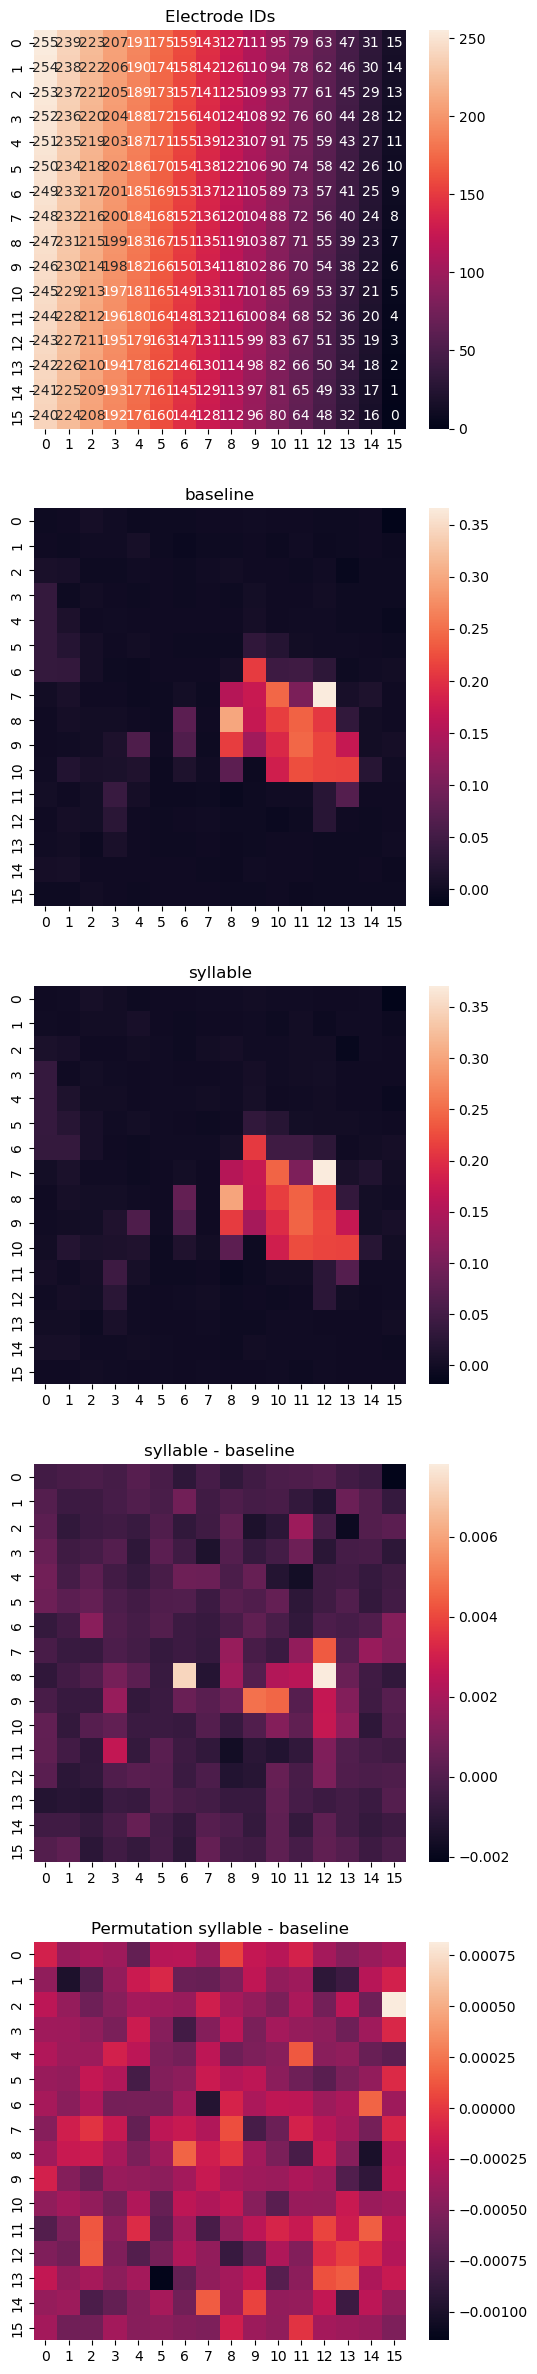

In [14]:
# plot as grid
num_output_dims = len(model1_scores.output_dim.unique())
grid_num_rows = np.ceil(np.sqrt(num_output_dims)).astype(int)
grid_num_cols = np.ceil(num_output_dims / grid_num_rows).astype(int)

def output_dim_to_grid_coords(output_dim):
    return grid_num_cols - output_dim // grid_num_cols - 1, grid_num_rows - output_dim % grid_num_rows - 1

electrode_grid = np.zeros((grid_num_rows, grid_num_cols)) * np.nan
for i in range(num_output_dims):
    x, y = output_dim_to_grid_coords(i)
    electrode_grid[y, x] = i

scores_grid = np.zeros((2, grid_num_rows, grid_num_cols)) * np.nan
for i, scores in enumerate([model1_scores, model2_scores]):
    for output_dim, scores_rows in scores.groupby("output_dim"):
        x, y = output_dim_to_grid_coords(output_dim)
        scores_grid[i, y, x] = scores_rows.score.mean()

scores_diff_grid = np.zeros((grid_num_rows, grid_num_cols)) * np.nan
for output_dim, scores_rows in all_improvements.groupby("output_dim"):
    x, y = output_dim_to_grid_coords(output_dim)
    scores_diff_grid[y, x] = scores_rows.mean()

permutation_scores_diff_grid = np.zeros((grid_num_rows, grid_num_cols)) * np.nan
for output_dim, scores_rows in permutation_improvements.groupby("output_dim"):
    x, y = output_dim_to_grid_coords(output_dim)
    permutation_scores_diff_grid[y, x] = scores_rows.mean()


f, axs = plt.subplots(5, 1, figsize=(6, 6 * 5))

# Sanity check: plot electrode IDs in grid form. Cross-check this with recon
sns.heatmap(electrode_grid, annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Electrode IDs")

sns.heatmap(scores_grid[0], ax=axs[1])
axs[1].set_title(model1)

sns.heatmap(scores_grid[1], ax=axs[2])
axs[2].set_title(model2)

sns.heatmap(scores_diff_grid, ax=axs[3])
axs[3].set_title(f"{model2} - {model1}")

sns.heatmap(permutation_scores_diff_grid, ax=axs[4])
axs[4].set_title(f"Permutation {model2} - {model1}")

## Quantitative

In [15]:
positive_improvement = all_improvements.groupby("output_dim").mean() > 0
print(f"Electrodes showing numerical improvement over baseline: "
      f"{positive_improvement.sum()} ({positive_improvement.mean() * 100:.2f}%)")

Electrodes showing numerical improvement over baseline: 85 (33.20%)


In [16]:
study_improvements = all_improvements.loc[positive_improvement[positive_improvement].index]
study_permutation_improvements = permutation_improvements.loc[positive_improvement[positive_improvement].index] \
    .groupby(["output_dim", "fold", "permutation"]).mean()

In [17]:
# Most stringent picture: take the minimum difference between full model and ANY permuted model,
# marginalizing over permutation type
improvements_over_permutation = (study_improvements - study_permutation_improvements) \
    .groupby(["output_dim", "fold"]).min()

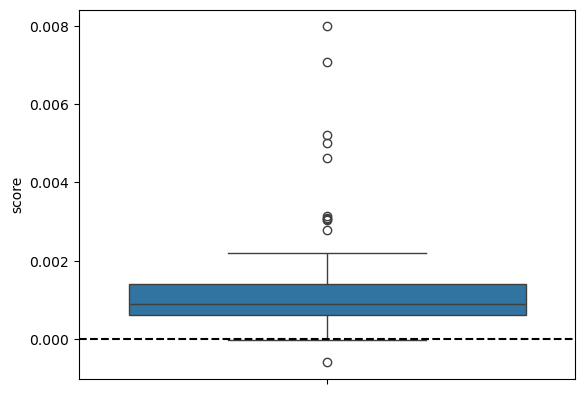

In [18]:
ax = sns.boxplot(improvements_over_permutation.groupby("output_dim").mean())
ax.axhline(0, color="k", linestyle="--")

In [19]:
ttest_improvements = all_improvements.loc[positive_improvement[positive_improvement].index]
ttest_permutation_improvements = permutation_improvements.loc[positive_improvement[positive_improvement].index]
ttest_results = (ttest_improvements - ttest_permutation_improvements) \
    .groupby(["output_dim", "permutation", "permutation_idx"]).mean() \
    .groupby(["output_dim", "permutation"]).apply(lambda xs: pd.Series(ttest_1samp(xs, 0), index=["tval", "pval"])) \
    .unstack() \
    .sort_values("pval")
ttest_results.to_csv(Path(output_dir) / "ttest_results.csv")
ttest_results

,,tval,pval
output_dim,permutation,,
56,units,39.154599,0.000003
151,units,38.489647,0.000003
53,units,31.066954,0.000006
86,units,29.987632,0.000007
55,units,28.529973,0.000009
...,...,...,...
254,units,1.332769,0.253457
13,units,-1.077327,0.341972
30,units,1.051629,0.352303


## Coefficient analysis

In [25]:
model2 = torch.load(model2_model_path)
model2_coefs = torch.load(model2_coefs_path)
coefs2_df = trf_grid_to_df(model2, model2_coefs)

In [26]:
# Plot max-norm of coef within feature across space
coefs2_df["base_feature"] = coefs2_df.feature.str.split(r"_[\d]", n=1).str[0]
coefs2_norms = coefs2_df.groupby(["base_feature", "lag", "output_dim", "fold"]).apply(lambda xs: np.linalg.norm(xs.coef)).groupby(["base_feature", "lag", "output_dim"]).mean()
coefs2_norms

base_feature      lag  output_dim
F0                0    0             0.000948
                       1             0.000871
                       2             0.000359
                       3             0.000710
                       4             0.000763
                                       ...   
phnfeatConsOnset  60   251           0.002549
                       252           0.002645
                       253           0.001846
                       254           0.002136
                       255           0.001081
Length: 93696, dtype: float64

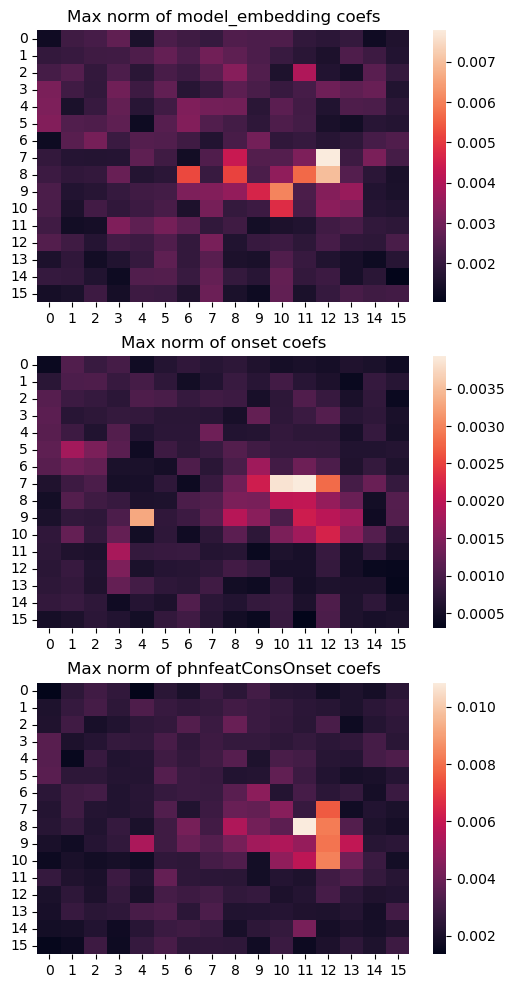

In [27]:
grid_features = ["aud", "onset", "phnfeatConsOnset", "model_embedding"]
grid_features = list(set(grid_features) & set(coefs2_norms.index.get_level_values("base_feature")))

if len(model1_scores.output_dim.unique()) == grid_num_rows * grid_num_cols:
    spatial_norm_grid = np.zeros((len(grid_features), grid_num_rows, grid_num_cols)) * np.nan
    for i, grid_feature in enumerate(grid_features):
        for output_dim, coef_dim_norms in coefs2_norms.loc[grid_feature].groupby("output_dim"):
            x, y = output_dim_to_grid_coords(output_dim)
            spatial_norm_grid[i, y, x] = coef_dim_norms.max()

    f, axs = plt.subplots(len(grid_features), 1, figsize=(6, 4 * len(grid_features)))
    for i, ax in enumerate(axs):
        sns.heatmap(spatial_norm_grid[i], ax=ax)
        ax.set_title(f"Max norm of {grid_features[i]} coefs")

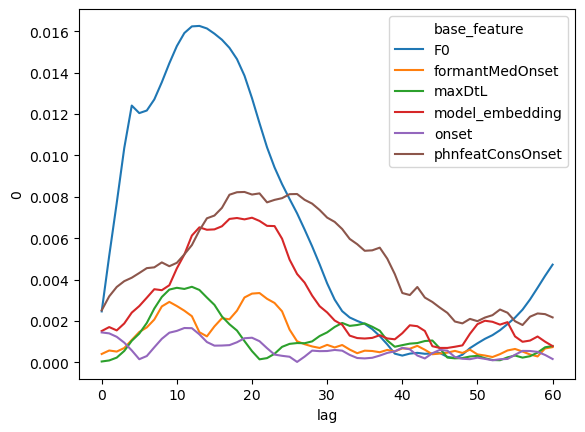

In [28]:
if "model_embedding" in grid_features:
    sns.lineplot(data=coefs2_norms.xs(coefs2_norms.loc["model_embedding"].groupby("output_dim").sum().argmax(), level="output_dim").reset_index(),
                x="lag", y=0, errorbar=None, hue="base_feature")

<Axes: xlabel='lag', ylabel='0'>

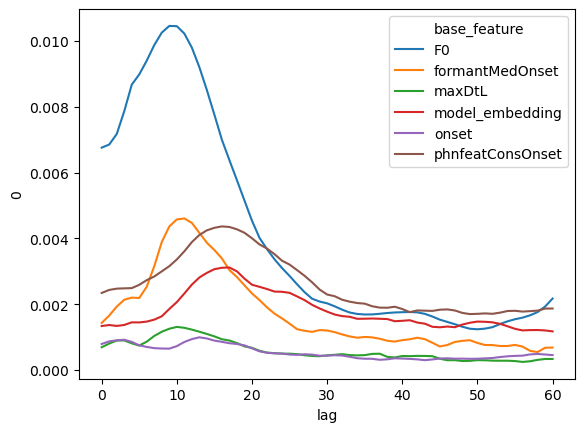

In [36]:
# Plot coefficient norm for just those electrodes well predicted
pval_threshold = 1e-3
significant_electrodes = ttest_results[(ttest_results.tval > 0) & (ttest_results.pval < pval_threshold)] \
    .index.get_level_values("output_dim").unique()
significant_electrodes_coefs = coefs2_df[coefs2_df.output_dim.isin(significant_electrodes)]
significant_electrodes_coefs_norms = significant_electrodes_coefs.groupby(["base_feature", "lag", "output_dim", "fold"]).apply(lambda xs: np.linalg.norm(xs.coef)).groupby(["base_feature", "lag", "output_dim"]).mean()

sns.lineplot(data=significant_electrodes_coefs_norms.reset_index(),
             x="lag", y=0, errorbar=None, hue="base_feature")